In [63]:
import torch
import torch.nn.functional as F
import torchaudio
import matplotlib.pyplot as plt
import math

In [55]:
# Zero Frequency Resonator
def zfr(x, wl=31):
    y_l, y_m = 0.0, 0.0
    y = []
    for x_n in x:
        y_n = -2 * y_m + y_l + x_n
        
        # remove exploding trend
        y_n = y_n - (y_n + y_m + y_l) / 3

        y.append(y_n)
        y_l, y_m = y_m, y_n
    
        
    return torch.stack(y)

# Trend Remover
def trm(x, wl=31):
    y = F.avg_pool1d(x.view(1, 1, -1), wl, padding=wl//2) 
    return y
        

In [157]:
# FIR version
# all zeros at z = -1
# h(z) = (0.99 + z)^P / z^P


# 計算 coef
# 長度是 p+1

def zff_fir(p=200, r=0.99, sr=8000):
    h = []
    for i in range(0, p+1): # 0-p
        c = math.comb(p, i)
        h_i = c * r**(p-i)
        h.append(h_i)
    m = max(h)
    h = [ x/m for x in h ] 
    h = torch.tensor(h)

    if sr != 8000:
        h = torchaudio.functional.resample(h, 8000, sr)
    
    return h

def filt(x, h, sr=8000):
    y = F.conv1d(x.view(1, 1, -1), h.view(1, 1, -1), padding=h.shape[0]//2)
    
    y = y.view(-1)
    return y


In [159]:
700 / 32000

0.021875

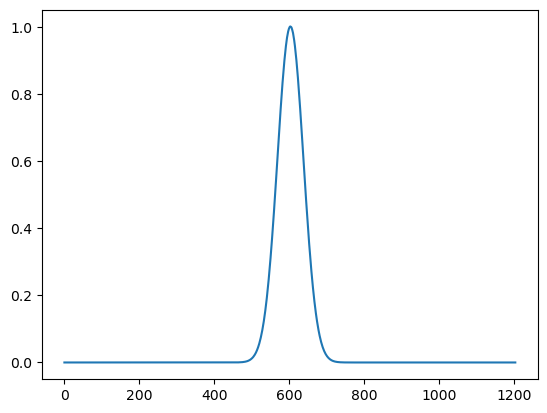

In [318]:
h = zff_fir(p=300, sr=32000)
plt.plot(h)

In [319]:
h.shape

torch.Size([1204])

In [320]:
# read a wav
filename = "../downloads/CMU_ARCTIC/cmu_us_bdl_arctic/orig/arctic_a0002.wav"
#filename = "../downloads/CMU_ARCTIC/cmu_us_slt_arctic/orig/arctic_a0002.wav"
#filename = "../downloads/CMU_ARCTIC/cmu_us_jmk_arctic/orig/arctic_a0002.wav"
wav, sr = torchaudio.load(filename)


In [321]:
wav.shape, sr

(torch.Size([2, 117440]), 32000)

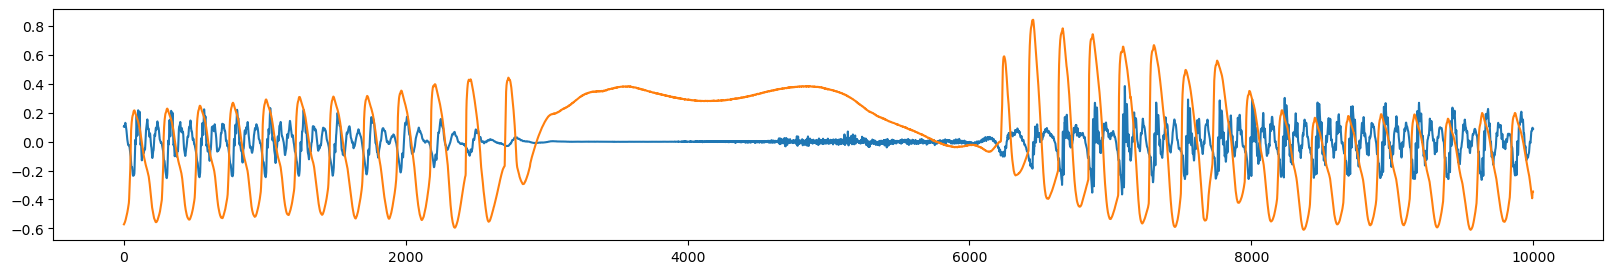

In [322]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(wav[0, 40000:50000])
ax.plot(-wav[1, 40000:50000])

In [323]:
# slt, bdl, jmk 的 EGG 極性似乎是相反的，但 wav 沒有 ?
# 有 synchronization 的問題。
# 



In [324]:
y1 = filt(wav[0], h)

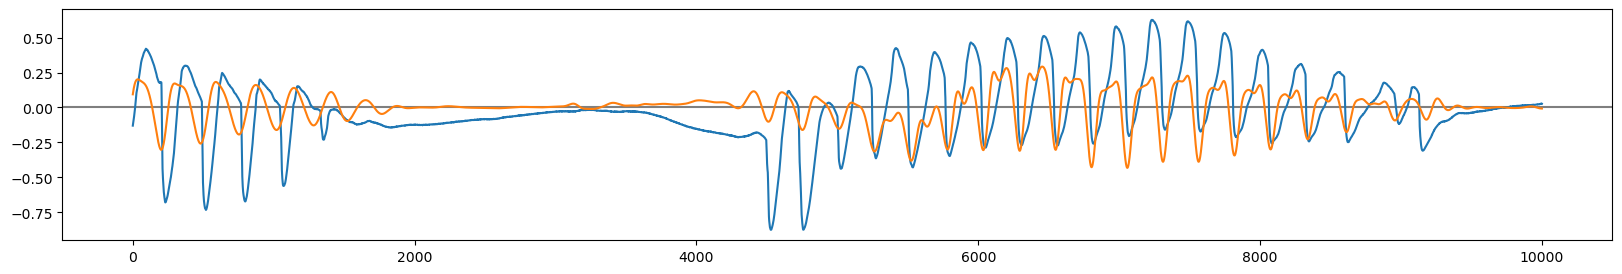

In [325]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 90000
ax.axhline(0, color='black', alpha=0.5)
ax.plot(wav[1, t:t+10000])
ax.plot(y1[t:t+10000]/10)


In [326]:
# read a wav
filename = "../downloads/CMU_ARCTIC/cmu_us_bdl_arctic/orig/arctic_a0004.wav"
#filename = "../downloads/CMU_ARCTIC/cmu_us_slt_arctic/orig/arctic_a0002.wav"
#filename = "../downloads/CMU_ARCTIC/cmu_us_jmk_arctic/orig/arctic_a0003.wav"
wav, sr = torchaudio.load(filename)

In [327]:
y1 = filt(wav[0], h)

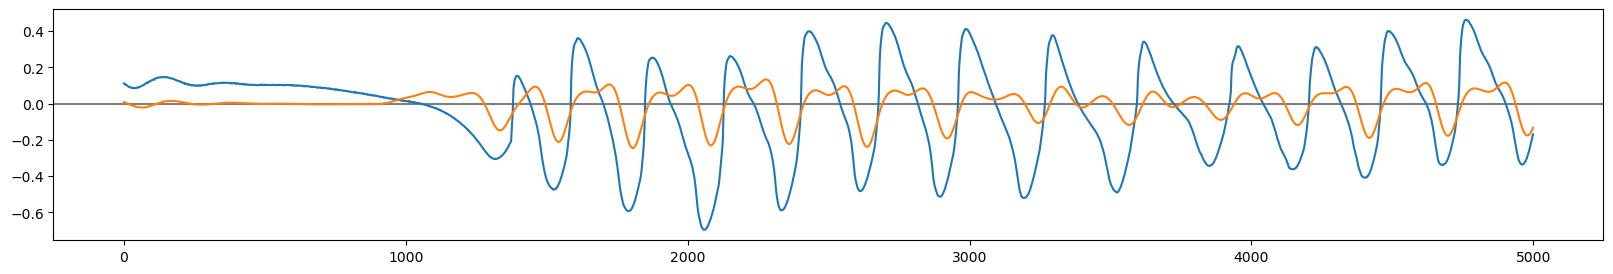

In [328]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 20000
l = 5000
ax.axhline(0, color='black', alpha=0.5)
#ax.plot(wav[0, t:t+10000])
ax.plot(-wav[1, t-50:t-50+l])
ax.plot(y1[t:t+l]/20)

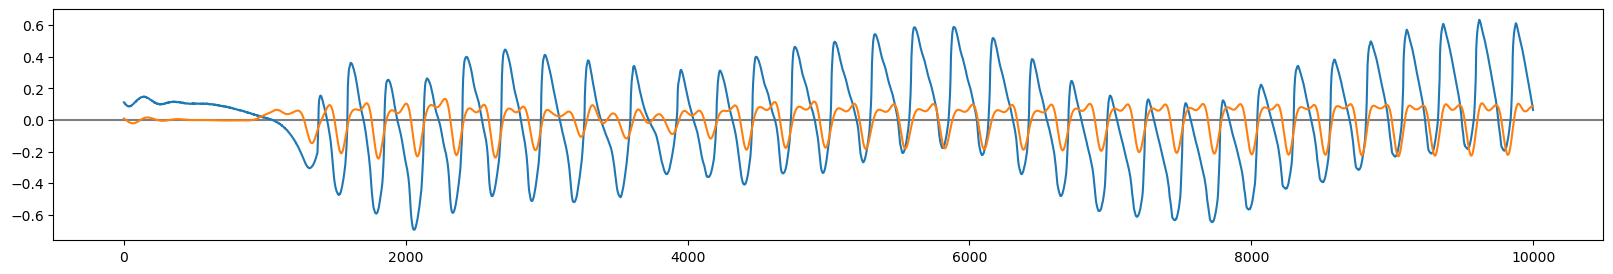

In [337]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 20000
ax.axhline(0, color='black', alpha=0.5)
#ax.plot(wav[0, t:t+10000])
ax.plot(-wav[1, t-50:t-50+10000])
ax.plot(y1[t:t+10000]/20)

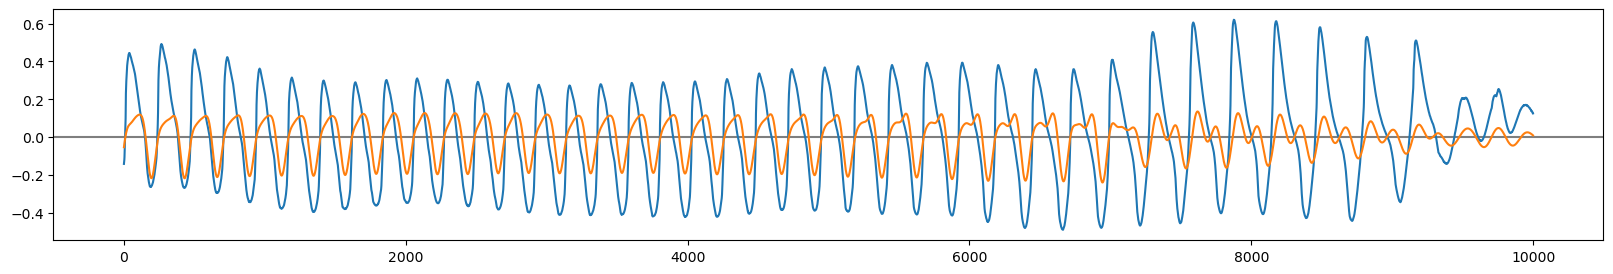

In [336]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 10000
ax.axhline(0, color='black', alpha=0.5)
#ax.plot(wav[0, t:t+10000])
ax.plot(-wav[1, t-60:t-60+10000])
ax.plot(y1[t:t+10000]/20)

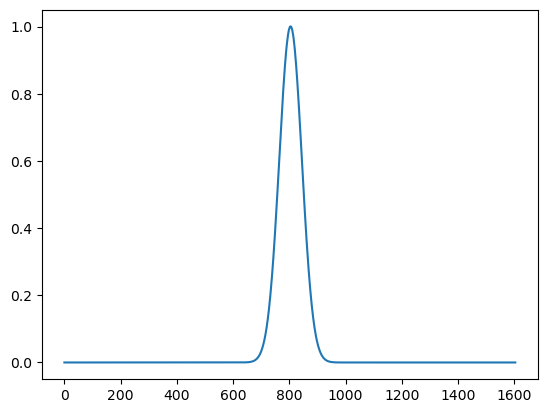

In [419]:
h = zff_fir(p=400, sr=32000)
plt.plot(h)

In [428]:
# read a wav
#filename = "../downloads/CMU_ARCTIC/cmu_us_bdl_arctic/orig/arctic_a0004.wav"
filename = "../downloads/CMU_ARCTIC/cmu_us_slt_arctic/orig/arctic_a0040.wav"
#filename = "../downloads/CMU_ARCTIC/cmu_us_jmk_arctic/orig/arctic_a0003.wav"
wav, sr = torchaudio.load(filename)

In [429]:
y1 = filt(wav[0], h)

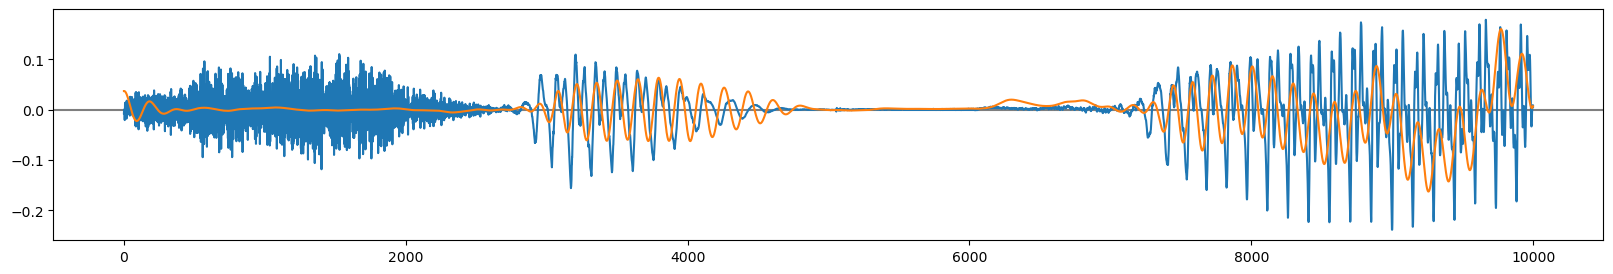

In [433]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 10000
ax.axhline(0, color='black', alpha=0.5)
#ax.plot(wav[0, t:t+10000])
ax.plot(wav[0, t+120:t+120+10000])
ax.plot(y1[t:t+10000]/20)

In [435]:
def zcp(x):
    p = []
    for n in range(1, x.shape[0]):
        if (x[n] > 0) and (x[n-1] <=0):
            p.append(n)
    return p

In [436]:
p = zcp(y1)

<StemContainer object of 3 artists>

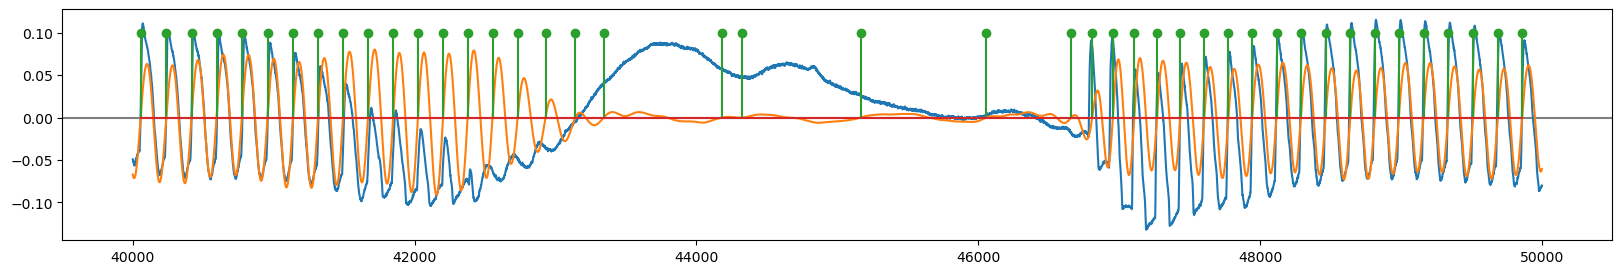

In [458]:
fig, ax = plt.subplots(1,1, figsize=(20,3))
t = 40000

_time = torch.arange(t, t+10000)

ax.axhline(0, color='black', alpha=0.5)
#ax.plot(wav[0, t:t+10000])
ax.plot(_time, -wav[1, t+120:t+120+10000])
ax.plot(_time, y1[t:t+10000]/20)

# filter the p
_p = torch.tensor([x for x in p if t < x < t + 10000])
_y = torch.ones_like(_p) * 0.1
ax.stem(_p.numpy(), _y.numpy(), 'C2-')

In [499]:
# 下面對 APLAWDW 的資料抽取  ZFF_PM
import pathlib
g = torch.hann_window(1401)
g /= g.sum()
h = zff_fir(p=400, sr=20000)

In [466]:
lines = open("../data/APLAWDW_wav.txt", "r").readlines()

In [496]:
for line in lines:
    in_fp = pathlib.Path("..")/"data"/line.strip()
    base = in_fp.stem
    out_fp = pathlib.Path("..")/"data"/"APLAWDW_WAV_ZFF"/ f"{base}.wav.txt"
    
    wav, sr = torchaudio.load(str(in_fp))
    y1 = filt(wav[0], h)
    p = zcp(y1)

    out_fp.parent.mkdir(parents=True, exist_ok=True)
    with out_fp.open("w") as out_f:
        for p_i in p:
            out_f.write(f"{p_i}\n")

In [501]:
for line in lines:
    in_fp = pathlib.Path("..")/"data"/line.strip()
    base = in_fp.stem
    out_fp = pathlib.Path("..")/"data"/"APLAWDW_WAV_ZFFLP"/ f"{base}.wav.txt"
    
    wav, sr = torchaudio.load(str(in_fp))
    y0 = filt(wav[0], g)
    y1 = filt(wav[0] - y0, h)
    p = zcp(y1)

    out_fp.parent.mkdir(parents=True, exist_ok=True)
    with out_fp.open("w") as out_f:
        for p_i in p:
            out_f.write(f"{p_i}\n")

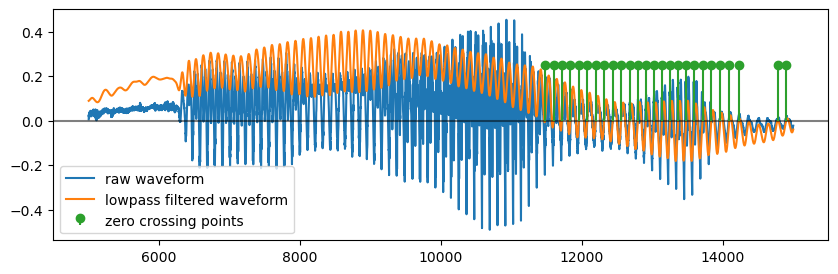

In [495]:
# ZFF as03i1
in_fp = pathlib.Path("..")/"data"/"APLAWDW"/"s"/"03"/"i"/"as03i1.wav"
h = zff_fir(p=400, sr=20000)
wav, sr = torchaudio.load(str(in_fp))
y1 = filt(wav[0], h)
p = zcp(y1)

fig, ax = plt.subplots(1,1, figsize=(10,3))
t = 5000

_time = torch.arange(t, t+10000)


#ax.plot(wav[0, t:t+10000])
ax.plot(_time, wav[0, t:t+10000], label="Raw waveform")
ax.plot(_time, y1[t:t+10000]/20, label="Filtered waveform" )
ax.axhline(0, color='black', alpha=0.5)

# filter the p
_p = torch.tensor([x for x in p if t < x < t + 10000])
_y = torch.ones_like(_p)*0.25
ax.stem(_p.numpy(), _y.numpy(), 'C2-', basefmt=" ", label="zero crossing points")

ax.legend()
fig.savefig("ZFF_as03i1.pdf", bbox_inches = 'tight',  pad_inches = 0.1)

In [502]:
h.shape

torch.Size([1003])

In [506]:
# 下面對 30 句 slt, jmk, bdl
g = torch.hann_window(2199)
g /= g.sum()
h = zff_fir(p=400, sr=32000)


lines = open("../data/CMU_ARCTICS_SJB30.txt", "r").readlines()
for line in lines:
    in_fp = pathlib.Path("..")/"data"/line.strip()
    spk = in_fp.parent.stem
    base = in_fp.stem
    out_fp = pathlib.Path("..")/"data"/"CMU_ARCTICS_SJB30_HPZFF"/ spk /f"{base}.wav.txt"
    
    wav, sr = torchaudio.load(str(in_fp))
    y0 = filt(wav[0], g)
    y1 = filt(wav[0] - y0, h)
    p = zcp(y1)

    out_fp.parent.mkdir(parents=True, exist_ok=True)
    with out_fp.open("w") as out_f:
        for p_i in p:
            out_f.write(f"{p_i}\n")


In [503]:
1401 * 32000 / 20000

2241.6